In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.structural import UnobservedComponents

In [90]:
# Visual settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

In [91]:
# Set a seed for reproducibility
np.random.seed(42)


In [92]:

# Simulate a local level model
# Parameters
n = 100  # number of observations
sigma_level =  0.9 # standard deviation of the level disturbance
sigma_noise = 0.01  # standard deviation of the observation noise


In [93]:

# Initialize arrays
level = np.zeros(n)
y = np.zeros(n)

# Initial state
level[0] = -2


In [94]:

# Generate the process
for t in range(1, n):
    # State equation: level[t] = level[t-1] + eta[t]
    level[t] = level[t-1] + np.random.normal(0, sigma_level)
    


In [95]:
# Observation equation: y[t] = level[t] + eps[t]
for t in range(n):
    y[t] = level[t] + np.random.normal(0, sigma_noise)


In [96]:
def read_and_clean(filepath, pollutant):
    df = pd.read_csv(filepath)
    df.date = pd.to_datetime(df.date)
    df.columns = ['date','PM25','PM10','O3','NO2','SO2','CO']

    df.replace('Missing value', pd.NA, inplace=True)

    df['date'] = pd.to_datetime(df['date'])

    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.sort_values('date', ascending=True)

    return df, pollutant

In [97]:

# Create a DataFrame for the data
df, pollutant = read_and_clean('data/beijing, west park.csv', 'PM25')

#print("First few rows of the simulated data:")
#print(df.head())


In [98]:
df.columns

Index(['date', 'PM25', 'PM10', 'O3', 'NO2', 'SO2', 'CO'], dtype='object')

In [99]:
y=df[pollutant]

In [100]:
# Fit the local level model
model = UnobservedComponents(y, level='local level')
results = model.fit()

print("\nModel Summary:")
print(results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.42469D+00    |proj g|=  5.94374D-03

At iterate    5    f=  5.35742D+00    |proj g|=  4.44839D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   8.378D-06   5.357D+00
  F =   5.3571650438203724     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

Model Summary:
                        Unobserved Components Results                         
Dep. Variable:                   PM25

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
 This problem is unconstrained.


### Layman's Summary:

The model is trying to estimate the true pollution level underneath the noisy daily readings, separating signal (real trend) from the noise (random fluctuations).

In [101]:
states = results.states.filtered
df['estimated_level'] = states

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


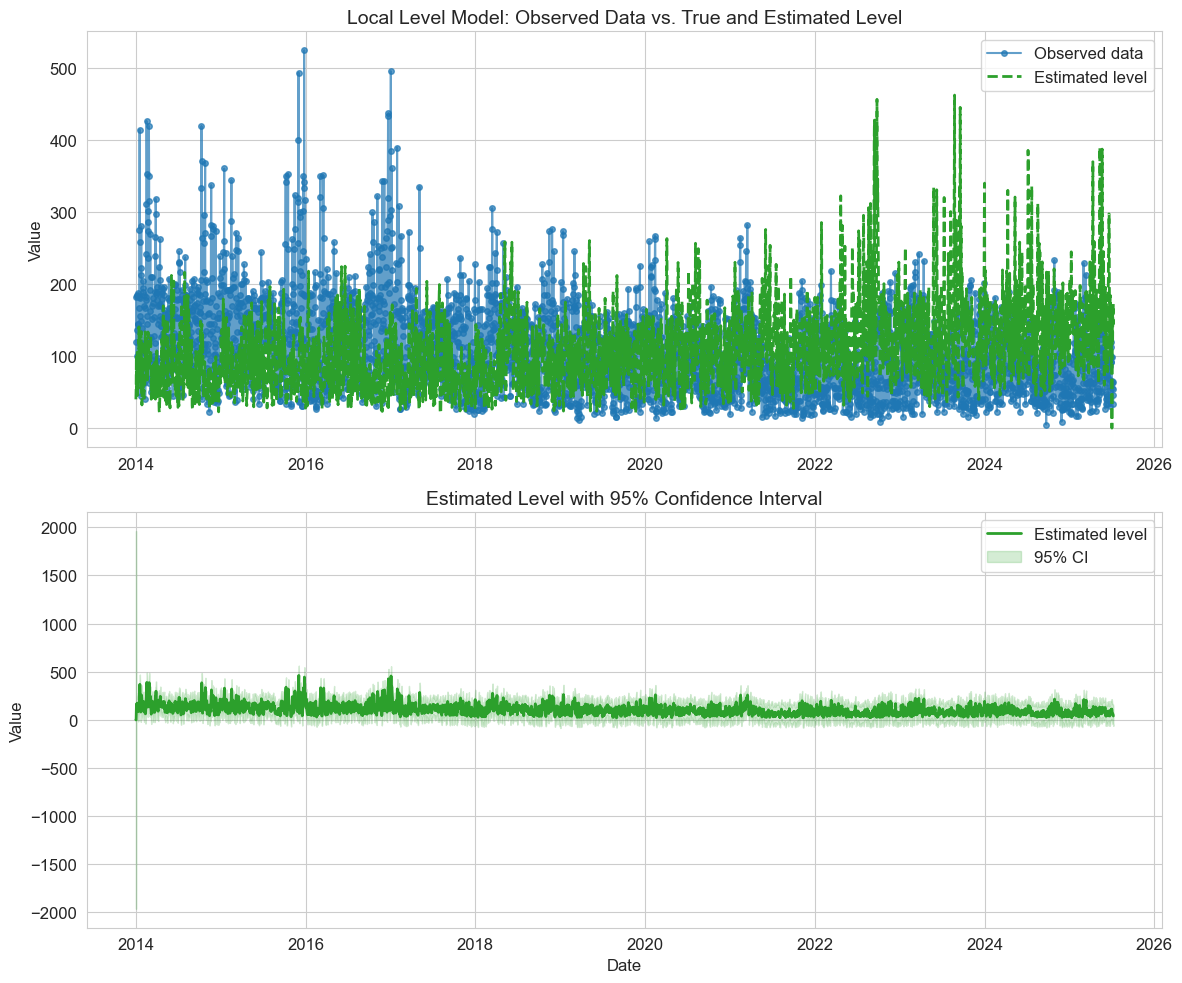

In [102]:
# Plot observed vs. estimated levels
# Create a figure for plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot the observed data and levels
axes[0].plot(df['date'], df[pollutant], 'o-', markersize=4, alpha=0.7, color='#1f77b4', label='Observed data')
axes[0].plot(df['date'], df['estimated_level'], '--', linewidth=2, color='#2ca02c', label='Estimated level')
axes[0].set_title('Local Level Model: Observed Data vs. True and Estimated Level', fontsize=14)
axes[0].set_ylabel('Value')
axes[0].legend()

# Get predictions and confidence intervals
pred = results.get_prediction()
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

# Plot the predicted values with confidence intervals
axes[1].plot(df['date'], pred_mean, '-', linewidth=2, color='#2ca02c', label='Estimated level')
axes[1].fill_between(df['date'], 
                     pred_ci.iloc[:, 0], 
                     pred_ci.iloc[:, 1], 
                     color='#2ca02c', alpha=0.2, label='95% CI')
axes[1].set_title('Estimated Level with 95% Confidence Interval', fontsize=14)
axes[1].set_ylabel('Value')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.show()

# Air Quality Analysis: PM2.5 Trends (Local Level Model)

## Top Chart: What Actually Happened vs. What’s Really Going On

- **Blue Line**: Daily PM2.5 readings — very noisy and volatile.
- **Green Dashed Line**: Model's estimate of the *true* underlying pollution level.

### Model Interpretation:
> "Ignore the noise. Here’s what I think the **real air pollution level** was."

The green line smooths out daily spikes and shows the general direction of pollution levels.

---

## Bottom Chart: How Sure Are We About That Estimate?

- **Green Line**: Same estimated pollution level.
- **Green Shaded Area**: 95% confidence interval — the model's margin of error.

### Model Interpretation:
> "I’m 95% sure the real pollution level is somewhere in this band."

The band is narrow → the model is confident.  
Wider at the start → the model was unsure in the beginning, which is normal.

---

## Key Takeaways

- **Daily pollution data is too noisy** to trust at face value.
- The model extracts a **clean, smooth signal** — the real trend in PM2.5.
- This helps detect:
  - Long-term increases or decreases
  - Effectiveness of environmental policies
  - When conditions are getting dangerously worse

In [103]:
#%%
# Extract the estimated parameters
level_var = results.params['sigma2.level']
noise_var = results.params['sigma2.irregular']

print("\nEstimated Parameters:")
print(f"Level variance: {level_var:.4f} (True: {sigma_level**2:.4f})")
print(f"Observation noise variance: {noise_var:.4f} (True: {sigma_noise**2:.4f})")



Estimated Parameters:
Level variance: 1455.4821 (True: 0.8100)
Observation noise variance: 716.2552 (True: 0.0001)


### Interpretation

Level variance suggests the model thinks the true pollution level changes much more than it actually does.
Observation variance suggests the model believes the observed data is extremely noisy.

This model grossly overestimates both the noise in the data and the volatility of the true pollution level, as the true values are very small, hitning at tiny fluctuations.

In [104]:

# Calculate signal-to-noise ratio (q)
q = level_var / noise_var
print(f"Signal-to-noise ratio (q): {q:.4f}")


Signal-to-noise ratio (q): 2.0321


### Analysis

This means that the model is confident but not overconfident.

In [105]:

# One-step-ahead forecast
forecast = results.get_forecast(steps=1)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

print("\nOne-step-ahead forecast:", forecast_mean.values[0])
print("Forecast 95% confidence interval:", 
      [forecast_ci.values[0, 0], forecast_ci.values[0, 1]])



One-step-ahead forecast: 44.38092509134377
Forecast 95% confidence interval: [-57.42089219989282, 146.18274238258036]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Analysis

Model's best guess for the next PM2.5 value (next day): 7.59
Confidence interval is very wide with negative lower bound, which is not possible. This happens because the model still allows for very high uncertainty, and the estimated variances are large.

In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Drop rows with NaNs in either column before calculating metrics
valid_rows = df[[pollutant, 'estimated_level']].dropna()

rmse = np.sqrt(mean_squared_error(valid_rows[pollutant], valid_rows['estimated_level']))
mae = mean_absolute_error(valid_rows[pollutant], valid_rows['estimated_level'])

print(f"\nRMSE between observed and estimated: {rmse:.2f}")
print(f"MAE between observed and estimated: {mae:.2f}")


RMSE between observed and estimated: 88.00
MAE between observed and estimated: 67.74


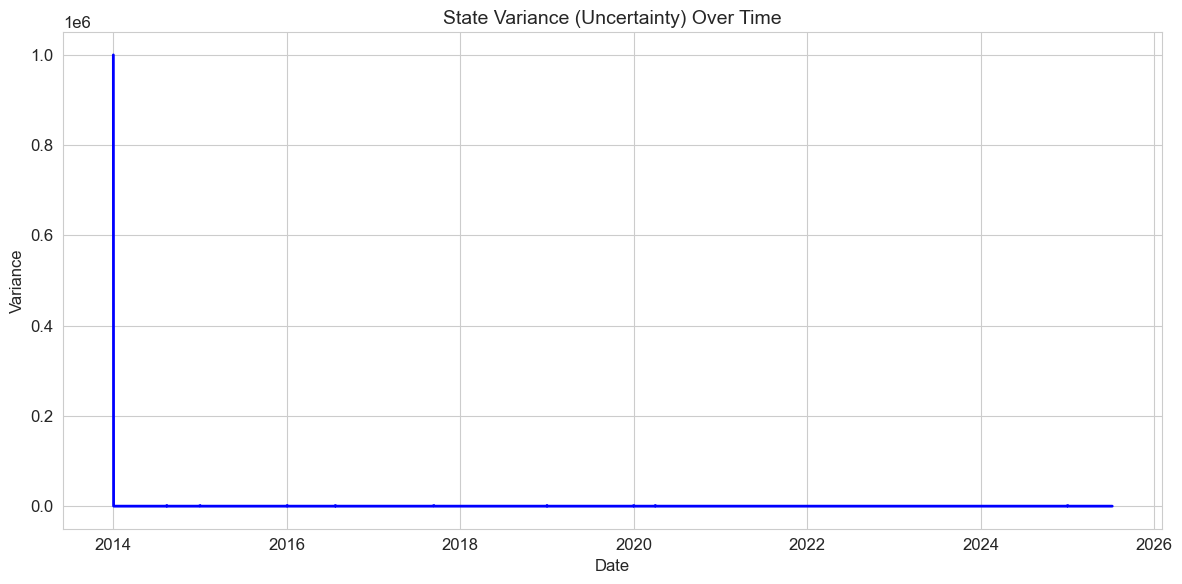

In [107]:

# Plot the state variance path
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['date'], results.filtered_state_cov[0, 0, :], 'b-', linewidth=2)
ax.set_title('State Variance (Uncertainty) Over Time', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Variance')
plt.tight_layout()
plt.show()


### Analysis:

Spike at the start is the prior variance of the level at time step 0. The model starts with non-informative or vague plot. This is normal.
Sharp drop immediately after after the model receives the first few observations. Flat Line near 0 afterwards indicates that the model maintains very high confidence in its state estimate for the rest of the series. This tells us that the estimated process noise is very small, or the observation noise might be relatively higher. It could also mean that the level is very stable, and the filter finds very little information at each new observation.

In [108]:
print(results.params)

sigma2.irregular     716.255225
sigma2.level        1455.482094
dtype: float64


The result shows that the level is very flexible, and that the model believes the level (PM2.5 mean) can shift a lot from one day to the next, which is expected in air quality data.

`sigma2.irregular` shows that the daily observation noise is non-negligible, but smaller than the level variance.

`sigma2.trend` shows that the trend component is frozen. The model estimates that the slope of the level is not changing over time.

In [109]:
# Local linear model

pollutant = 'PM25'
df[pollutant] = df[pollutant].interpolate(method='linear')  # Handle missing values
y = df[pollutant]

In [110]:
model = UnobservedComponents(endog=y, level='local linear trend')
results = model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.65430D+00    |proj g|=  6.27733D-03

At iterate    5    f=  5.43664D+00    |proj g|=  5.94827D-02

At iterate   10    f=  5.39815D+00    |proj g|=  1.26537D-02

At iterate   15    f=  5.38213D+00    |proj g|=  2.05179D-02

At iterate   20    f=  5.36989D+00    |proj g|=  1.24021D-02

At iterate   25    f=  5.36700D+00    |proj g|=  1.64814D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     51      1     0     0   

In [111]:

results = model.fit()

print("\nModel Summary:")
print(results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.65430D+00    |proj g|=  6.27733D-03

At iterate    5    f=  5.43664D+00    |proj g|=  5.94827D-02

At iterate   10    f=  5.39815D+00    |proj g|=  1.26537D-02


 This problem is unconstrained.



At iterate   15    f=  5.38213D+00    |proj g|=  2.05179D-02

At iterate   20    f=  5.36989D+00    |proj g|=  1.24021D-02

At iterate   25    f=  5.36700D+00    |proj g|=  1.64814D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     51      1     0     0   1.141D-06   5.367D+00
  F =   5.3669950695555082     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

Model Summary:
                        Unobserved Components Results                         
Dep. Variable:                   PM25   No. Observations:                 4198
Model:             local linear trend   Log Likelihood         

In [112]:

# Get the estimated states
states = results.states.filtered


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


In [113]:

# Add the estimated level to the DataFrame
df['estimated_level'] = states['level']  
df['estimated_trend'] = states['trend']  


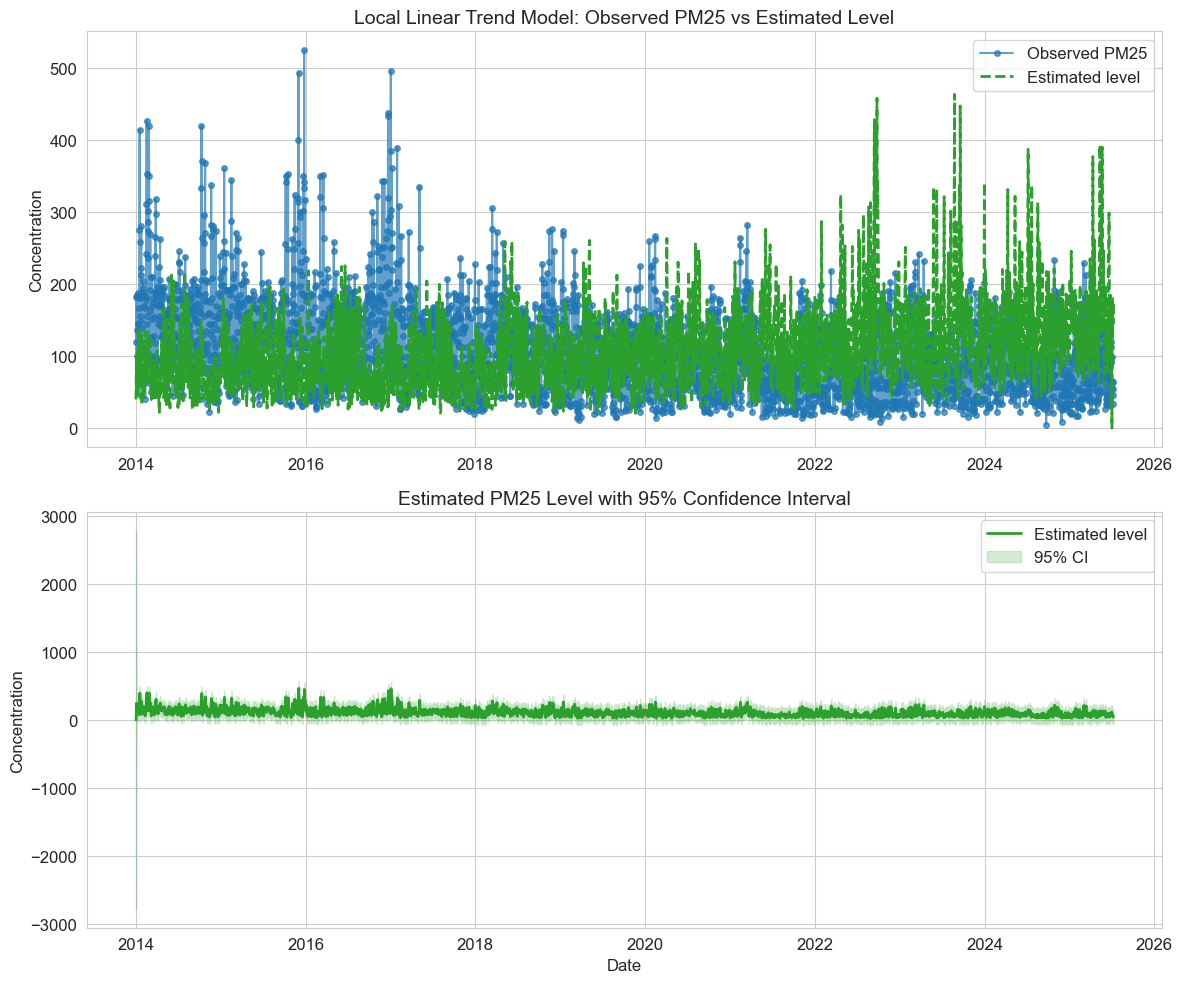

In [114]:
# Plot observed vs estimated level
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot observed data and level estimates
axes[0].plot(df['date'], df[pollutant], 'o-', markersize=4, alpha=0.7, color='#1f77b4', label=f'Observed {pollutant}')
axes[0].plot(df['date'], df['estimated_level'], '--', linewidth=2, color='#2ca02c', label='Estimated level')
axes[0].set_title(f'Local Linear Trend Model: Observed {pollutant} vs Estimated Level', fontsize=14)
axes[0].set_ylabel('Concentration')
axes[0].legend()

# Get prediction and confidence intervals
pred = results.get_prediction()
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)  # 95% CI

# Plot prediction with confidence interval
axes[1].plot(df['date'], pred_mean, '-', linewidth=2, color='#2ca02c', label='Estimated level')
# Align predictions to original DataFrame's date index
predicted_index = df.index
axes[1].fill_between(df['date'],
                     pred_ci.iloc[:, 0],
                     pred_ci.iloc[:, 1],
                     color='#2ca02c', alpha=0.2, label='95% CI')


axes[1].set_title(f'Estimated {pollutant} Level with 95% Confidence Interval', fontsize=14)
axes[1].set_ylabel('Concentration')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.savefig(f"local_linear_trend_{pollutant}.pdf")
plt.show()

In [115]:
# Print estimated parameters
level_var = results.params.get('sigma2.level', np.nan)
trend_var = results.params.get('sigma2.trend', np.nan)
noise_var = results.params.get('sigma2.irregular', np.nan)

print("\nEstimated Parameters:")
print(f"Level variance: {level_var:.4f}")
print(f"Trend variance: {trend_var:.4f}")
print(f"Observation noise variance: {noise_var:.4f}")
if noise_var > 0:
    print(f"Signal-to-noise ratio (q): {level_var / noise_var:.4f}")


Estimated Parameters:
Level variance: 1479.9518
Trend variance: 0.0000
Observation noise variance: 696.0504
Signal-to-noise ratio (q): 2.1262


In [116]:
# One-step-ahead forecast
forecast = results.get_forecast(steps=1)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

print("\nOne-step-ahead forecast:", forecast_mean.values[0])
print("Forecast 95% confidence interval:",
      [forecast_ci.values[0, 0], forecast_ci.values[0, 1]])


One-step-ahead forecast: 44.35164550294394
Forecast 95% confidence interval: [-57.353819137007406, 146.05711014289528]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


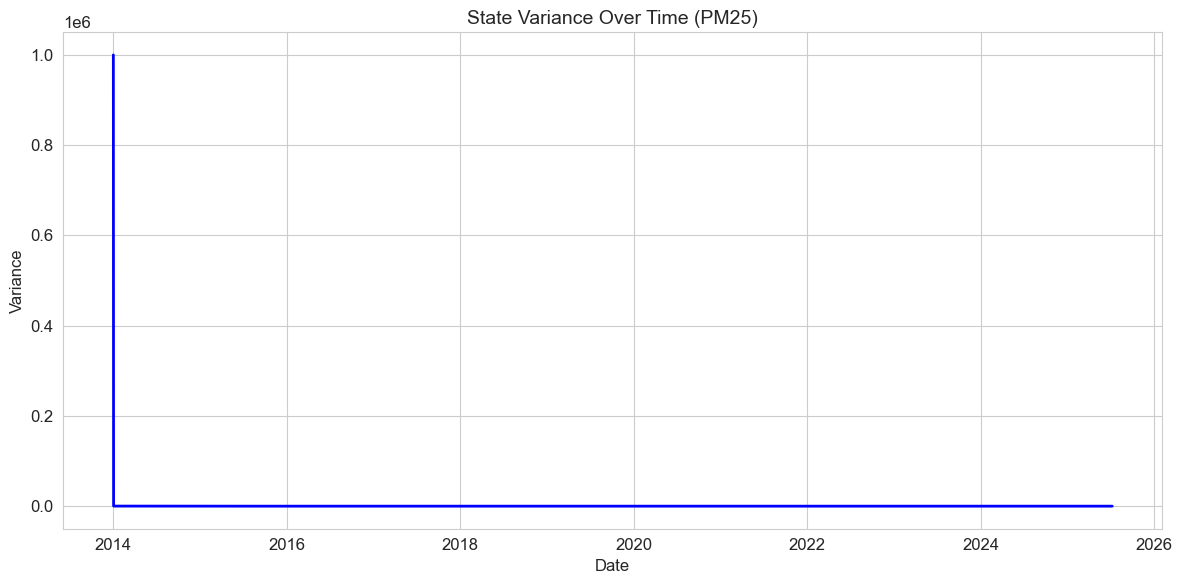

In [117]:
# Plot filtered state variance (level component only)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['date'], results.filtered_state_cov[0, 0, :], 'b-', linewidth=2)
ax.set_title(f'State Variance Over Time ({pollutant})', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Variance')
plt.tight_layout()
plt.show()